In [3]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 42.6 MB/s eta 0:00:00


In [61]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from sentence_transformers import SentenceTransformer
import faiss
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt


In [134]:
# Function to generate synthetic data
def generate_synthetic_data(num_records=600000, start_date='2023-06-01', end_date='2023-12-01'):
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')

    # List of service names
    services = ['order-srv-1', 'order-srv-2', 'vendor-srv-1','vendor-srv-2']

    data = []
    for _ in range(num_records):
        timestamp = random.choice(date_range)
        service_name = random.choice(services)
        cpu_usage = random.uniform(30, 100)
        memory_usage = random.uniform(30, 100)

        data.append([timestamp, service_name, cpu_usage, memory_usage])

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'service_name', 'cpu_usage', 'memory_usage'])
    return df

# Generate synthetic data
synthetic_data = generate_synthetic_data(num_records=600000)

# Save synthetic data to CSV
synthetic_data.to_csv('synthetic_data.csv', index=False)

# Display the first few records of the generated data
synthetic_data.head()


<ipython-input-134-940204434cb4>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='H')


,timestamp,service_name,cpu_usage,memory_usage
0,2023-07-13 03:00:00,vendor-srv-2,82.378967,80.362825
1,2023-10-16 02:00:00,order-srv-2,37.391916,45.447027
2,2023-07-22 21:00:00,order-srv-1,43.481587,92.864833
3,2023-09-13 23:00:00,vendor-srv-2,48.860168,51.901102
4,2023-06-18 04:00:00,order-srv-1,40.540506,97.105977


In [136]:
# Load the synthetic data
synthetic_data = pd.read_csv('synthetic_data.csv')

# Convert timestamp to datetime
synthetic_data['timestamp'] = pd.to_datetime(synthetic_data['timestamp'])

# Sort the data by timestamp to ensure proper merging
synthetic_data.sort_values(by='timestamp', inplace=True)

# Handle missing values (we can use interpolation, forward-fill, or back-fill)
synthetic_data.fillna(method='ffill', inplace=True)

# Display the cleaned data
synthetic_data.head()


<ipython-input-136-8e0c0497958f>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  synthetic_data.fillna(method='ffill', inplace=True)


,timestamp,service_name,cpu_usage,memory_usage
433266,2023-06-01,vendor-srv-1,45.032605,30.608897
364023,2023-06-01,order-srv-2,42.672695,74.457736
103801,2023-06-01,vendor-srv-1,59.760482,52.201068
402009,2023-06-01,vendor-srv-1,67.798437,77.529187
415078,2023-06-01,order-srv-2,37.216617,81.504605


In [137]:


# ------------------ Anomaly Detection ------------------

# Prepare features for anomaly detection
metrics_features = synthetic_data[['cpu_usage', 'memory_usage']]

# Apply Isolation Forest to detect anomalies
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
synthetic_data['anomaly'] = (isolation_forest.fit_predict(metrics_features) == -1).astype(int)

# ------------------ Print Detected Anomalies ------------------

# Filter detected anomalies
detected_anomalies = synthetic_data[synthetic_data['anomaly'] == 1]


# Separate anomalies for CPU and memory usage (optional)
cpu_anomalies = detected_anomalies[detected_anomalies['cpu_usage'] > detected_anomalies['memory_usage']]
memory_anomalies = detected_anomalies[detected_anomalies['memory_usage'] > detected_anomalies['cpu_usage']]

# Print CPU anomalies
print("\nDetected CPU Anomalies:")
print(cpu_anomalies[['timestamp', 'service_name', 'cpu_usage']])

# Print Memory anomalies
print("\nDetected Memory Anomalies:")
print(memory_anomalies[['timestamp', 'service_name', 'memory_usage']])



Detected CPU Anomalies:
                 timestamp  service_name  cpu_usage
433266 2023-06-01 00:00:00  vendor-srv-1  45.032605
255845 2023-06-01 00:00:00  vendor-srv-1  77.946528
470580 2023-06-01 00:00:00  vendor-srv-2  99.308487
41923  2023-06-01 01:00:00   order-srv-2  99.326150
558254 2023-06-01 02:00:00   order-srv-1  99.494432
...                    ...           ...        ...
464183 2023-11-30 23:00:00   order-srv-1  44.505362
466606 2023-11-30 23:00:00  vendor-srv-2  99.616236
20131  2023-12-01 00:00:00   order-srv-1  44.142766
267378 2023-12-01 00:00:00  vendor-srv-1  99.732291
100462 2023-12-01 00:00:00   order-srv-1  34.856661

[13640 rows x 3 columns]

Detected Memory Anomalies:
                 timestamp  service_name  memory_usage
515105 2023-06-01 00:00:00   order-srv-2     31.260758
289368 2023-06-01 00:00:00  vendor-srv-1     99.201331
74731  2023-06-01 00:00:00  vendor-srv-1     98.510127
434377 2023-06-01 00:00:00  vendor-srv-2     35.133911
271080 2023-06-01 01:0

In [138]:
# Combine anomalies into one DataFrame
detected_anomalies = pd.concat([cpu_anomalies[['timestamp', 'service_name', 'cpu_usage', ]],
                          memory_anomalies[['timestamp', 'service_name', 'memory_usage', ]]],
                         ignore_index= False)

# Save the anomalies to a CSV file
detected_anomalies.to_csv('detected_anomalies.csv', index=False)

# Display the anomalies
print(detected_anomalies)

                 timestamp  service_name  cpu_usage  memory_usage
433266 2023-06-01 00:00:00  vendor-srv-1  45.032605           NaN
255845 2023-06-01 00:00:00  vendor-srv-1  77.946528           NaN
470580 2023-06-01 00:00:00  vendor-srv-2  99.308487           NaN
41923  2023-06-01 01:00:00   order-srv-2  99.326150           NaN
558254 2023-06-01 02:00:00   order-srv-1  99.494432           NaN
...                    ...           ...        ...           ...
331738 2023-12-01 00:00:00  vendor-srv-2        NaN     99.467652
103220 2023-12-01 00:00:00  vendor-srv-1        NaN     98.868948
483301 2023-12-01 00:00:00  vendor-srv-2        NaN     38.180231
545189 2023-12-01 00:00:00  vendor-srv-2        NaN     89.295023
268041 2023-12-01 00:00:00   order-srv-2        NaN     50.903377

[29999 rows x 4 columns]


In [139]:

# ------------------ FAISS Embedding Setup ------------------

# Use the anomaly data from synthetic_data
embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Create descriptions for anomalies
anomaly_descriptions = [
    f"Metrics anomaly at {row['timestamp']}: CPU usage {row['cpu_usage']:.2f}%, Memory usage {row['memory_usage']:.2f}%"
    for _, row in detected_anomalies.iterrows()
]

# Generate embeddings for the anomaly descriptions
anomaly_embeddings = embedding_model.encode(anomaly_descriptions)

# Build FAISS index with the anomaly embeddings
faiss_index = faiss.IndexFlatL2(anomaly_embeddings.shape[1])
faiss_index.add(np.array(anomaly_embeddings, dtype=np.float32))


In [140]:
# ------------------ Retrieve Relevant Anomalies ------------------
def get_relevant_anomalies(description):
    # Get the embedding for the new anomaly description
    new_embedding = embedding_model.encode([description])

    # Search for relevant historical anomalies in the FAISS index
    distances, indices = faiss_index.search(np.array(new_embedding, dtype=np.float32), k=3)

    # Print the retrieved relevant anomalies
    relevant_anomalies = [anomaly_descriptions[i] for i in indices[0]]

    # Print the relevant anomalies
    print("Detected Anomaly:", description)
    print("Relevant Historical Anomalies:")
    for anomaly in relevant_anomalies:
        print(f"- {anomaly}")

    return relevant_anomalies

# Example usage: Retrieve the last detected anomaly from synthetic_data
new_anomalies = synthetic_data[synthetic_data['anomaly'] == 1].tail(1)
for index, row in new_anomalies.iterrows():
    # Create description for the new anomaly
    anomaly_description = f"Metrics anomaly at {row['timestamp']}: CPU usage {row['cpu_usage']:.2f}%, Memory usage {row['memory_usage']:.2f}%"

    # Get relevant historical anomalies from FAISS and print them
    relevant_anomalies = get_relevant_anomalies(anomaly_description)

    # Further processing with GPT-2 or any other logic can follow here
    historical_context = "\n".join(relevant_anomalies)

    # Generate GPT-2 response or further insight generation...



Detected Anomaly: Metrics anomaly at 2023-12-01 00:00:00: CPU usage 34.86%, Memory usage 31.60%
Relevant Historical Anomalies:
- Metrics anomaly at 2023-07-24 04:00:00: CPU usage 98.36%, Memory usage nan%
- Metrics anomaly at 2023-09-20 04:00:00: CPU usage 33.58%, Memory usage nan%
- Metrics anomaly at 2023-09-24 04:00:00: CPU usage 37.81%, Memory usage nan%


In [141]:
# ------------------ GPT-2 Insight Generation ------------------
# Load the pre-trained model and tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Function to generate GPT-2 response
def generate_response(prompt, max_length=600):
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(inputs['input_ids'], max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2, top_p=0.92, temperature=0.7)

    # Decode and return the response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response


In [142]:
# ------------------ Process New Anomalies ------------------
new_anomalies = synthetic_data[synthetic_data['anomaly'] == 1].tail(1)
for index, row in new_anomalies.iterrows():
    # Create description for the new anomaly
    anomaly_description = f"Metrics anomaly at {index}: CPU usage {row['cpu_usage']:.2f}%, Memory usage {row['memory_usage']:.2f}%"

    # Get relevant historical anomalies from FAISS
    # relevant_anomalies = get_relevant_anomalies(anomaly_description)
    # historical_context = "\n".join(relevant_anomalies)

    # Create GPT-2 prompt with a more direct instruction for a solution
    prompt = f"Historical anomalies:\n{historical_context}\n\n"
    prompt += f"New anomaly detected: {anomaly_description}\n"
    prompt += "What is the likely cause and possible solution for this anomaly? "
    # Generate GPT-2 response
    insight = generate_response(prompt)

    # Print the results
    print("GPT-2 Insight:\n", insight)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


GPT-2 Insight:
 Historical anomalies:
Metrics anomaly at 2023-07-24 04:00:00: CPU usage 98.36%, Memory usage nan%
Metrics anomaly at 2023-09-20 04:00:00: CPU usage 33.58%, Memory usage nan%
Metrics anomaly at 2023-09-24 04:00:00: CPU usage 37.81%, Memory usage nan%

New anomaly detected: Metrics anomaly at 100462: CPU usage 34.86%, Memory usage 31.60%
What is the likely cause and possible solution for this anomaly?  The most likely explanation is that the CPU is not using enough memory to handle the new data.    The CPU has to be able to process the data in a timely manner.
The CPU can't handle all the information that is being processed. The data is too large to store in memory. This is why the CPUs are not able for the first time to perform the computation. 
This is because the memory is so large that it is difficult to read the entire data and store it in the same place.  
In order to solve this problem, the processor must be capable of processing the large data at a time. In order 

In [143]:
print(synthetic_data.columns)


Index(['timestamp', 'service_name', 'cpu_usage', 'memory_usage', 'anomaly'], dtype='object')


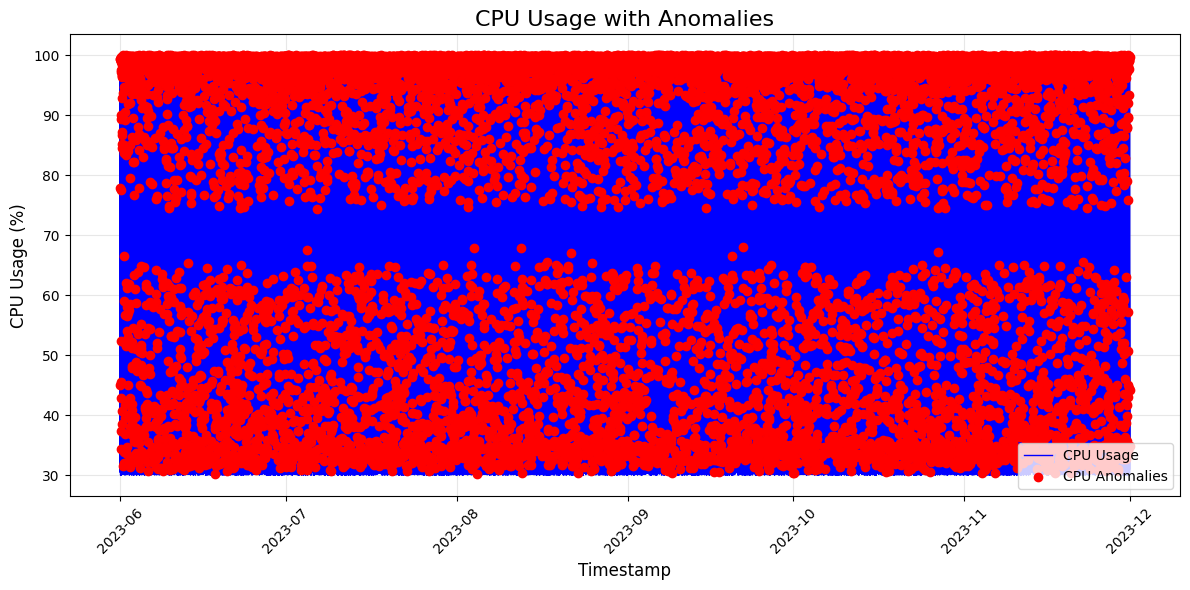

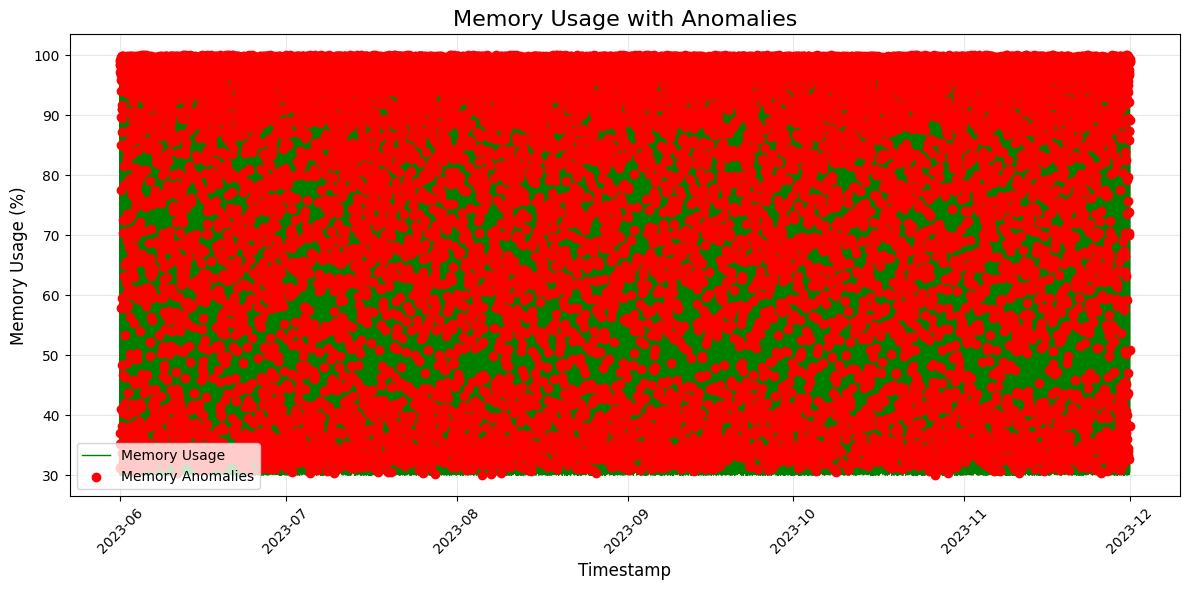

In [144]:
import matplotlib.pyplot as plt

# Ensure the 'timestamp' column is sorted for better visualization
synthetic_data = synthetic_data.sort_values(by='timestamp')

# Plot CPU usage and highlight anomalies
plt.figure(figsize=(12, 6))
plt.plot(synthetic_data['timestamp'], synthetic_data['cpu_usage'], label='CPU Usage', color='blue', linewidth=1)
plt.scatter(cpu_anomalies['timestamp'], cpu_anomalies['cpu_usage'], color='red', label='CPU Anomalies', zorder=3)
plt.title('CPU Usage with Anomalies', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('CPU Usage (%)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Memory usage and highlight anomalies
plt.figure(figsize=(12, 6))
plt.plot(synthetic_data['timestamp'], synthetic_data['memory_usage'], label='Memory Usage', color='green', linewidth=1)
plt.scatter(memory_anomalies['timestamp'], memory_anomalies['memory_usage'], color='red', label='Memory Anomalies', zorder=3)
plt.title('Memory Usage with Anomalies', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Memory Usage (%)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
